### **0. Library**

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

### **1. Data Load**

In [2]:
# 데이터 로드
DATA_PATH = "/data/ephemeral/home/workspace/upstageailab-ml-competition-ml-2/1.Data/"

train_path = DATA_PATH + 'naver_api_XY.csv'
test_path  = DATA_PATH +'naver_api_XY.csv'
train = pd.read_csv(train_path).query('is_train == 1')
test = pd.read_csv(test_path).query('is_train == 0')



In [3]:
# 문자열 변경을 위한 re import
import re

key_list = {}

for text in list(train.columns):
    # '전용면적별세대현황'으로 시작하면 괄호 제거 안함
    if text.startswith('k-전용면적별세대'): # 그냥 괄호를 제거하면 중복된 이름이 발생하기 때문에 처리한 예외 처리 
        cleaned = re.sub(r'^k-', '', text).strip()

    else :
        cleaned = re.sub(r'\(.*?\)','',text)
        cleaned = re.sub(r'^k-','',cleaned)
        cleaned = cleaned.strip()
    key_list[text] = cleaned
print(key_list)

train = train.rename(columns = key_list)
test = test.rename(columns = key_list)

{'시군구': '시군구', '번지': '번지', '본번': '본번', '부번': '부번', '아파트명': '아파트명', '전용면적(㎡)': '전용면적', '계약년월': '계약년월', '계약일': '계약일', '층': '층', '건축년도': '건축년도', '도로명': '도로명', '해제사유발생일': '해제사유발생일', '등기신청일자': '등기신청일자', '거래유형': '거래유형', '중개사소재지': '중개사소재지', 'k-단지분류(아파트,주상복합등등)': '단지분류', 'k-전화번호': '전화번호', 'k-팩스번호': '팩스번호', '단지소개기존clob': '단지소개기존clob', 'k-세대타입(분양형태)': '세대타입', 'k-관리방식': '관리방식', 'k-복도유형': '복도유형', 'k-난방방식': '난방방식', 'k-전체동수': '전체동수', 'k-전체세대수': '전체세대수', 'k-건설사(시공사)': '건설사', 'k-시행사': '시행사', 'k-사용검사일-사용승인일': '사용검사일-사용승인일', 'k-연면적': '연면적', 'k-주거전용면적': '주거전용면적', 'k-관리비부과면적': '관리비부과면적', 'k-전용면적별세대현황(60㎡이하)': '전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)': '전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하': '85㎡~135㎡이하', 'k-135㎡초과': '135㎡초과', 'k-홈페이지': '홈페이지', 'k-등록일자': '등록일자', 'k-수정일자': '수정일자', '고용보험관리번호': '고용보험관리번호', '경비비관리형태': '경비비관리형태', '세대전기계약방법': '세대전기계약방법', '청소비관리형태': '청소비관리형태', '건축면적': '건축면적', '주차대수': '주차대수', '기타/의무/임대/임의=1/2/3/4': '기타/의무/임대/임의=1/2/3/4', '단지승인일': '단지승인일', '사용허가여부': '사용허가여부', '관리비 업로드': '관리비 업로드

In [4]:
# Data pre-processing

## is_train : train/test 구분을 위한 변수
## concat을 통한 train, test 합쳐주기

train['is_train'] = 1
test['is_train'] = 0
concat = pd.concat([train, test])

print(concat.shape)
print(concat['is_train'].value_counts())

(1174387, 54)
is_train
1    1164913
0       9474
Name: count, dtype: int64


In [5]:
# 결측치는 아닌데 의미 없는 형식적 값 찾는 함수

def detect_fake_nulls(df, suspect_values=['-', ' ', '', '.', '없음', 'nan']):
    result = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            val_counts = df[col].value_counts(dropna=False)
            found = val_counts[val_counts.index.isin(suspect_values)]
            if not found.empty:
                result[col] = found
    return result

fake_nulls = detect_fake_nulls(concat)
for col, vals in fake_nulls.items():
    print(f"🔎 {col} 컬럼에서 의미 없는 값 발견:")
    print(vals)
    print()

# 아무 의미 없는 값 결측처리를 위해 nan으로 변경
concat['도로명'] = concat['도로명'].replace(' ', np.nan)
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

🔎 도로명 컬럼에서 의미 없는 값 발견:
도로명
    39963
Name: count, dtype: int64

🔎 등기신청일자 컬럼에서 의미 없는 값 발견:
등기신청일자
    1157291
Name: count, dtype: int64

🔎 거래유형 컬럼에서 의미 없는 값 발견:
거래유형
-    1131755
Name: count, dtype: int64

🔎 중개사소재지 컬럼에서 의미 없는 값 발견:
중개사소재지
-    1135340
Name: count, dtype: int64

🔎 시행사 컬럼에서 의미 없는 값 발견:
시행사
.    868
-    152
Name: count, dtype: int64

🔎 홈페이지 컬럼에서 의미 없는 값 발견:
홈페이지
없음    3628
.       72
Name: count, dtype: int64



In [6]:
# 파생 변수 6. dist_to_CBD,  dist_to_Gangnam, dist_to_Yeouido
%pip install haversine
from haversine import haversine

center_coords = {
    'CBD':     (37.5714, 126.9768),
    'Gangnam': (37.4979, 127.0276),
    'Yeouido': (37.5219, 126.9245)
}

concat['dist_to_CBD'] = concat.apply(lambda row : haversine((row['좌표Y'], row['좌표X']), center_coords['CBD']) if pd.notnull(row['좌표X']) and pd.notnull(row['좌표Y']) else 9999, axis=1)
concat['dist_to_Gangnam'] = concat.apply(lambda row : haversine((row['좌표Y'], row['좌표X']), center_coords['Gangnam']) if pd.notnull(row['좌표X']) and pd.notnull(row['좌표Y']) else 9999 , axis=1)
concat['dist_to_Yeouido'] = concat.apply(lambda row : haversine((row['좌표Y'], row['좌표X']), center_coords['Yeouido']) if pd.notnull(row['좌표X']) and pd.notnull(row['좌표Y']) else 9999 , axis=1)


Note: you may need to restart the kernel to use updated packages.


In [7]:
concat.drop(axis = 1, columns=['좌표X','좌표Y'], inplace=True)

In [8]:
# 결측률 30% 이상 삭제
concat.drop(axis = 1, columns = list(concat.columns[concat.isnull().sum()/concat.shape[0] >= 0.3]), inplace=True)

In [9]:
# categorical column name, numerical column name return function
def split_categorical_numerical(df:pd.DataFrame, verbose:bool = True):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if verbose:
        print("📌 범주형 변수:", categorical_cols)
        print("📌 연속형 변수:", numerical_cols)
    return categorical_cols, numerical_cols

# update and check variable
cat_cols, num_cols = split_categorical_numerical(concat)

📌 범주형 변수: ['시군구', '번지', '아파트명', '도로명', 'full_address']
📌 연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_train', 'dist_to_CBD', 'dist_to_Gangnam', 'dist_to_Yeouido']


In [10]:
concat.drop(axis = 1, columns=['본번', '부번', '계약일', '번지', '아파트명', '도로명'])

시군구    전용면적    계약년월   층  건축년도    target  is_train  \
0        서울특별시 강남구 개포동   79.97  201712   3  1987  124000.0         1   
1        서울특별시 강남구 개포동   79.97  201712   4  1987  123500.0         1   
2        서울특별시 강남구 개포동   54.98  201712   5  1987   91500.0         1   
3        서울특별시 강남구 개포동   79.97  201801   4  1987  130000.0         1   
4        서울특별시 강남구 개포동   79.97  201801   2  1987  117000.0         1   
...                ...     ...     ...  ..   ...       ...       ...   
1174382  서울특별시 중랑구 신내동   84.65  202307  13  2014       NaN         0   
1174383  서울특별시 중랑구 신내동   84.62  202307  12  2014       NaN         0   
1174384  서울특별시 중랑구 신내동  101.65  202308  12  2014       NaN         0   
1174385  서울특별시 중랑구 신내동   84.94  202309  18  2014       NaN         0   
1174386  서울특별시 중랑구 신내동   84.65  202309  13  2014       NaN         0   

                    full_address  dist_to_CBD  dist_to_Gangnam  \
0            서울특별시 강남구 개포동 언주로 3    12.689473          3.51418   
1            서울특별시 강남구 개포동 언주로 3    12.689473          3.51418   
2            서울특별시 강남구 개포동 언주로 3    12.689473          3.51418   
3            서울특별시 강남구 개포동 언주로 3    12.689473          3.51418   
4            서울특별시 강남구 개포동 언주로 3    12.689473          3.51418   
...                          ...          ...              ...   
1174382  서울특별시 중랑구 신내동 신내역로1길 85    12.604935         15.15178   
1174383  서울특별시 중랑구 신내동 신내역로1길 85    12.604935         15.15178   
1174384  서울특별시 중랑구 신내동 신내역로1길 85    12.604935         15.15178   
1174385  서울특별시 중랑구 신내동 신내역로1길 85    12.604935         15.15178   
1174386  서울특별시 중랑구 신내동 신내역로1길 85    12.604935         15.15178   

         dist_to_Yeouido  
0              12.737866  
1              12.737866  
2              12.737866  
3              12.737866  
4              12.737866  
...                  ...  
1174382        19.343687  
1174383        19.343687  
1174384        19.343687  
1174385        19.343687  
1174386        19.343687  

[1174387 rows x 11 columns]

In [11]:
concat['contract_month'] = concat['계약년월'] % 100 # 계약월
concat['contract_date'] = concat['계약년월']//100 + concat['contract_month'] / 12 # 계약시간

concat['covid'] = (concat['계약년월'] >= 202001).astype(int) # 코로나 시기 구분

# 빌딩의 나이
current = 2025
concat['apt_age'] = current - concat['건축년도']

# 
concat['구'] = list(map(lambda x : x.split(' ')[1],concat['시군구']))
concat['동'] = list(map(lambda x : x.split(' ')[2],concat['시군구']))

concat.drop(axis = 1, columns = ['건축년도', '계약년월', '시군구', '계약일', '본번', '부번', '도로명', '번지', '아파트명'], inplace = True)

In [12]:
cat_cols, num_cols = split_categorical_numerical(concat)

📌 범주형 변수: ['full_address', '구', '동']
📌 연속형 변수: ['전용면적', '층', 'target', 'is_train', 'dist_to_CBD', 'dist_to_Gangnam', 'dist_to_Yeouido', 'contract_month', 'contract_date', 'covid', 'apt_age']


전용면적 클리핑 모듈 로드 완료!
사용법: %run area_clipping_module.ipynb
       concat = apply_area_clipping(concat)

전용면적 이상치 클리핑 시작
[전용면적] 클리핑 완료!
   총 데이터: 1,174,387개
   클리핑된 데이터: 11,582개 (0.99%)
   클리핑 경계:
      - 하위 0.5%: 14.02㎡
      - 상위 99.5%: 196.54㎡
   새 컬럼명: '전용면적_clip'


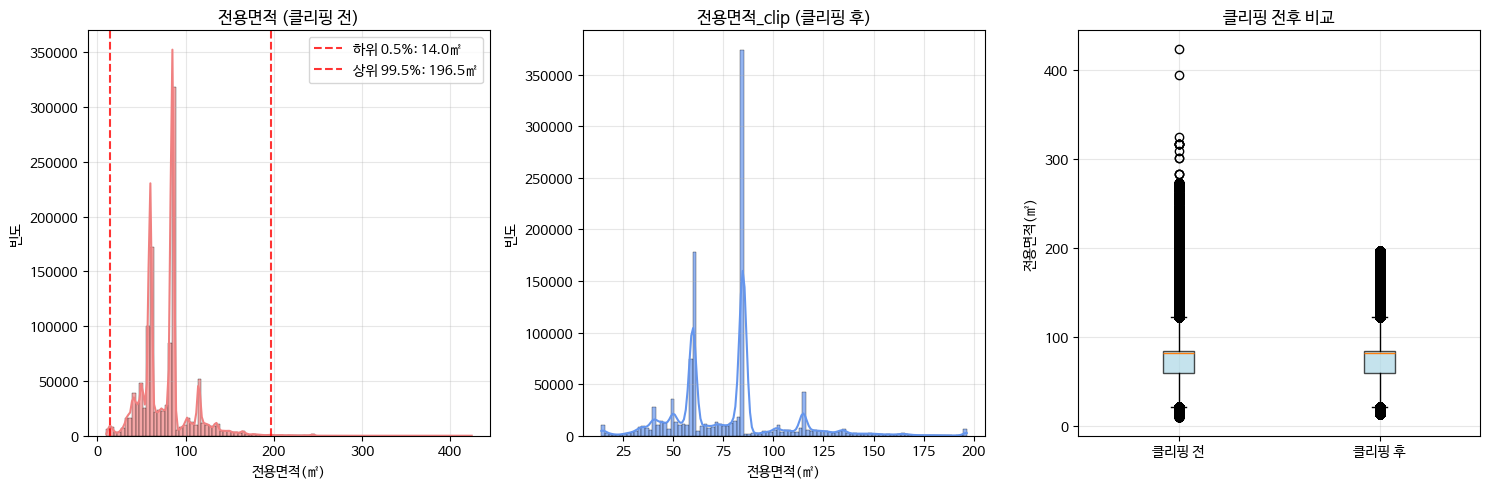

전용면적 클리핑 완료!


In [13]:
%run ../3.src/area_clipping_module.ipynb
concat = apply_area_clipping(concat)

In [14]:
concat.drop(axis = 1, columns = ['전용면적'], inplace = True)
concat.columns

Index(['층', 'target', 'is_train', 'full_address', 'dist_to_CBD',
       'dist_to_Gangnam', 'dist_to_Yeouido', 'contract_month', 'contract_date',
       'covid', 'apt_age', '구', '동', '전용면적_clip'],
      dtype='object')

In [15]:
# train set, test set split
df_train = concat.query('is_train == 1')
df_test = concat.query('is_train == 0')

# 이제 is_test 칼럼은 drop해줍니다.
df_train.drop(['is_train'], axis = 1, inplace=True)
df_test.drop(['is_train'], axis = 1, inplace=True)
print(df_train.shape, df_test.shape)

(1164913, 13) (9474, 13)


In [16]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( cat_cols ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


In [17]:
# Target과 독립변수들을 분리해줍니다.
y_train_log = np.log1p(df_train['target'])
X_train = df_train.drop(['target'], axis=1)
test_data = df_test.drop(axis = 1, columns=['target'])


In [28]:
# Feature Selection 을 위해  임시로  RandomForestRegressor 한 번 돌려보기

from sklearn.ensemble import RandomForestRegressor


rf_temp = RandomForestRegressor(
    n_estimators=200,
    criterion='squared_error',
    random_state=42,
    n_jobs=-1,
    max_depth=20
)


rf_temp.fit(X_train, y_train_log)

feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_temp.feature_importances_
})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

# 표로 확인
print(feature_importances)

            feature  importance
11        전용면적_clip    0.402228
6     contract_date    0.207076
3   dist_to_Gangnam    0.192135
8           apt_age    0.055360
1      full_address    0.050009
4   dist_to_Yeouido    0.035187
2       dist_to_CBD    0.031191
10                동    0.016255
0                 층    0.004819
9                 구    0.004240
5    contract_month    0.001457
7             covid    0.000042


In [ ]:
# threshold = 0.01
# selected_features = feature_importances[feature_importances['importance'] >= threshold]['feature'].tolist()

# print(f"Selected Features {len(selected_features)}:", selected_features)

Selected Features 8: ['전용면적_clip', 'contract_date', 'dist_to_Gangnam', 'apt_age', 'full_address', 'dist_to_Yeouido', 'dist_to_CBD', '동']


In [ ]:
# 1. 여러 threshold 실험
threshold_list = [0.20, 0.10, 0.03, 0.01, 0.004, 0.0001]

# 결과 저장용
results = []

# 3. 여러 threshold 실험
for threshold in threshold_list:
    # 중요도 기준으로 feature 선택
    selected_features = feature_importances[feature_importances['importance'] >= threshold]['feature'].tolist()
    
    X_train_selected = X_train[selected_features]
    
    # hold-out split
    X_training, X_validation, y_training, y_validation = train_test_split(X_train_selected, y_train_log, test_size=0.2, random_state=42)
    
    # 기본 RandomForestRegressor
    model = RandomForestRegressor(
        n_estimators=200,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1,
        max_depth=20
    )
  
    model.fit(X_training, y_training)
    
    # 예측 및 로그 복원
    y_pred_log = model.predict(X_validation)
    y_pred = np.expm1(y_pred_log)
    y_val_true = np.expm1(y_validation)
    
    rmse = np.sqrt(mean_squared_error(y_val_true, y_pred))
    
    print(f"[Threshold {threshold}] RMSE: {rmse:.2f}")
    results.append({'threshold': threshold, 'rmse': rmse, 'features': selected_features})

# 4. 가장 낮은 RMSE 선택
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['rmse'].idxmin()]
best_threshold = best_row['threshold']
best_features = best_row['features']
print(f"\n✅ Best Threshold: {best_threshold}, RMSE: {best_row['rmse']:.2f}")


# [Threshold 0.2] RMSE: 24240.72
# [Threshold 0.1] RMSE: 10814.88
# [Threshold 0.03] RMSE: 7102.45
# [Threshold 0.01] RMSE: 7080.49
# [Threshold 0.004] RMSE: 6883.29
# [Threshold 0.0001] RMSE: 6946.80

# ✅ Best Threshold: 0.004, RMSE: 6883.29



[Threshold 0.2] RMSE: 24240.72
[Threshold 0.1] RMSE: 10814.88
[Threshold 0.03] RMSE: 7102.45
[Threshold 0.01] RMSE: 7080.49
[Threshold 0.004] RMSE: 6883.29
[Threshold 0.0001] RMSE: 6946.80

✅ Best Threshold: 0.004, RMSE: 6883.29


In [30]:

# 5. GridSearchCV (선택된 best feature로만!)

from sklearn.model_selection import GridSearchCV

X_best = X_train[best_features]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2']
}

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_best, y_train_log)

# 최종 결과
print("\n🎯 Best GridSearch Params:", grid_search.best_params_)
print("📉 Best GridSearch RMSE:", -grid_search.best_score_)
cv_results = pd.DataFrame(grid_search.cv_results_)
display(cv_results[['params', 'mean_test_score', 'rank_test_score']])

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=  50.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=  50.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=  50.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=  51.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=  52.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=  53.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=  49.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, n_estimators=200; total time= 1.7min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=200; total time= 1.7min
[CV] END max_depth=10, max_features=sqrt, min_s

params  mean_test_score  \
0   {'max_depth': 10, 'max_features': 'sqrt', 'min...        -0.255508   
1   {'max_depth': 10, 'max_features': 'sqrt', 'min...        -0.255042   
2   {'max_depth': 10, 'max_features': 'sqrt', 'min...        -0.257229   
3   {'max_depth': 10, 'max_features': 'sqrt', 'min...        -0.256682   
4   {'max_depth': 10, 'max_features': 'sqrt', 'min...        -0.257059   
5   {'max_depth': 10, 'max_features': 'sqrt', 'min...        -0.256390   
6   {'max_depth': 10, 'max_features': 'log2', 'min...        -0.255508   
7   {'max_depth': 10, 'max_features': 'log2', 'min...        -0.255042   
8   {'max_depth': 10, 'max_features': 'log2', 'min...        -0.257229   
9   {'max_depth': 10, 'max_features': 'log2', 'min...        -0.256682   
10  {'max_depth': 10, 'max_features': 'log2', 'min...        -0.257059   
11  {'max_depth': 10, 'max_features': 'log2', 'min...        -0.256390   
12  {'max_depth': 20, 'max_features': 'sqrt', 'min...        -0.147987   
13  {'max_depth': 20, 'max_features': 'sqrt', 'min...        -0.147694   
14  {'max_depth': 20, 'max_features': 'sqrt', 'min...        -0.151510   
15  {'max_depth': 20, 'max_features': 'sqrt', 'min...        -0.151022   
16  {'max_depth': 20, 'max_features': 'sqrt', 'min...        -0.154272   
17  {'max_depth': 20, 'max_features': 'sqrt', 'min...        -0.153559   
18  {'max_depth': 20, 'max_features': 'log2', 'min...        -0.147987   
19  {'max_depth': 20, 'max_features': 'log2', 'min...        -0.147694   
20  {'max_depth': 20, 'max_features': 'log2', 'min...        -0.151510   
21  {'max_depth': 20, 'max_features': 'log2', 'min...        -0.151022   
22  {'max_depth': 20, 'max_features': 'log2', 'min...        -0.154272   
23  {'max_depth': 20, 'max_features': 'log2', 'min...        -0.153559   
24  {'max_depth': 30, 'max_features': 'sqrt', 'min...        -0.139804   
25  {'max_depth': 30, 'max_features': 'sqrt', 'min...        -0.139853   
26  {'max_depth': 30, 'max_features': 'sqrt', 'min...        -0.145243   
27  {'max_depth': 30, 'max_features': 'sqrt', 'min...        -0.144253   
28  {'max_depth': 30, 'max_features': 'sqrt', 'min...        -0.148907   
29  {'max_depth': 30, 'max_features': 'sqrt', 'min...        -0.148323   
30  {'max_depth': 30, 'max_features': 'log2', 'min...        -0.139804   
31  {'max_depth': 30, 'max_features': 'log2', 'min...        -0.139853   
32  {'max_depth': 30, 'max_features': 'log2', 'min...        -0.145243   
33  {'max_depth': 30, 'max_features': 'log2', 'min...        -0.144253   
34  {'max_depth': 30, 'max_features': 'log2', 'min...        -0.148907   
35  {'max_depth': 30, 'max_features': 'log2', 'min...        -0.148323   

    rank_test_score  
0                27  
1                25  
2                35  
3                31  
4                33  
5                29  
6                27  
7                25  
8                35  
9                31  
10               33  
11               29  
12               11  
13                9  
14               19  
15               17  
16               23  
17               21  
18               11  
19                9  
20               19  
21               17  
22               23  
23               21  
24                1  
25                3  
26                7  
27                5  
28               15  
29               13  
30                1  
31                3  
32                7  
33                5  
34               15  
35               13

In [ ]:
# 🎯 Best GridSearch Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
# 📉 Best GridSearch RMSE: 0.13980364876258938


# params	mean_test_score	rank_test_score
# 0	{'max_depth': 10, 'max_features': 'sqrt', 'min...	-0.255508	27
# 1	{'max_depth': 10, 'max_features': 'sqrt', 'min...	-0.255042	25
# 2	{'max_depth': 10, 'max_features': 'sqrt', 'min...	-0.257229	35
# 3	{'max_depth': 10, 'max_features': 'sqrt', 'min...	-0.256682	31
# 4	{'max_depth': 10, 'max_features': 'sqrt', 'min...	-0.257059	33
# 5	{'max_depth': 10, 'max_features': 'sqrt', 'min...	-0.256390	29
# 6	{'max_depth': 10, 'max_features': 'log2', 'min...	-0.255508	27
# 7	{'max_depth': 10, 'max_features': 'log2', 'min...	-0.255042	25
# 8	{'max_depth': 10, 'max_features': 'log2', 'min...	-0.257229	35
# 9	{'max_depth': 10, 'max_features': 'log2', 'min...	-0.256682	31
# 10	{'max_depth': 10, 'max_features': 'log2', 'min...	-0.257059	33
# 11	{'max_depth': 10, 'max_features': 'log2', 'min...	-0.256390	29
# 12	{'max_depth': 20, 'max_features': 'sqrt', 'min...	-0.147987	11
# 13	{'max_depth': 20, 'max_features': 'sqrt', 'min...	-0.147694	9
# 14	{'max_depth': 20, 'max_features': 'sqrt', 'min...	-0.151510	19
# 15	{'max_depth': 20, 'max_features': 'sqrt', 'min...	-0.151022	17
# 16	{'max_depth': 20, 'max_features': 'sqrt', 'min...	-0.154272	23
# 17	{'max_depth': 20, 'max_features': 'sqrt', 'min...	-0.153559	21
# 18	{'max_depth': 20, 'max_features': 'log2', 'min...	-0.147987	11
# 19	{'max_depth': 20, 'max_features': 'log2', 'min...	-0.147694	9
# 20	{'max_depth': 20, 'max_features': 'log2', 'min...	-0.151510	19
# 21	{'max_depth': 20, 'max_features': 'log2', 'min...	-0.151022	17
# 22	{'max_depth': 20, 'max_features': 'log2', 'min...	-0.154272	23
# 23	{'max_depth': 20, 'max_features': 'log2', 'min...	-0.153559	21
# 24	{'max_depth': 30, 'max_features': 'sqrt', 'min...	-0.139804	1
# 25	{'max_depth': 30, 'max_features': 'sqrt', 'min...	-0.139853	3
# 26	{'max_depth': 30, 'max_features': 'sqrt', 'min...	-0.145243	7
# 27	{'max_depth': 30, 'max_features': 'sqrt', 'min...	-0.144253	5
# 28	{'max_depth': 30, 'max_features': 'sqrt', 'min...	-0.148907	15
# 29	{'max_depth': 30, 'max_features': 'sqrt', 'min...	-0.148323	13
# 30	{'max_depth': 30, 'max_features': 'log2', 'min...	-0.139804	1
# 31	{'max_depth': 30, 'max_features': 'log2', 'min...	-0.139853	3
# 32	{'max_depth': 30, 'max_features': 'log2', 'min...	-0.145243	7
# 33	{'max_depth': 30, 'max_features': 'log2', 'min...	-0.144253	5
# 34	{'max_depth': 30, 'max_features': 'log2', 'min...	-0.148907	15
# 35	{'max_depth': 30, 'max_features': 'log2', 'min...	-0.148323	13


In [ ]:
# + 그리드 서치를 통해, 하이퍼 파라미터 튜닝 결과 → best model 파라미터로 예측 진행 ! 
# Best GridSearch Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
# Best GridSearch RMSE: 0.13980364876258938  


X_train_selected = X_train[best_features]

X_training, X_validation, y_training, y_validation = train_test_split(X_train_selected, y_train_log, test_size=0.2, random_state=42)

rf_best_model = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error',
    random_state=42,
    n_jobs=-1,
    max_features='sqrt',
    min_samples_leaf=1,
    max_depth=30
)


rf_best_model.fit(X_training, y_training)

y_pred_log = rf_best_model.predict(X_validation)
y_pred = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(np.expm1(y_validation), y_pred))
print(f"rf_best_model Validation RMSE: {rmse:.2f}")

# → best_model Validation RMSE: 6673.62

In [ ]:
# + 그리드 서치를 통해, 하이퍼 파라미터 튜닝 결과 → best model 파라미터로 예측 진행 ! 
# Best GridSearch Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
# Best GridSearch RMSE: 0.13980364876258938   → best_model Validation RMSE: 6673.62

%run ../3.src/utils.py

test_data_selected = test_data[best_features]
selected_feature_with_log_transform_pred = best_model.predict(test_data_selected)
selected_feature_with_log_transform_pred = np.expm1(selected_feature_with_log_transform_pred)
selected_feature_with_log_transform_pred = prepare_submission(selected_feature_with_log_transform_pred, test)

submission_selected_feature_with_log = pd.DataFrame({
    'target':selected_feature_with_log_transform_pred
})

# sub_250717_rf_v12  : 그리드 서치 모델 튜닝 + 네이버 api 좌표X, Y 추가 버전 + threshold 0.004 
save_path='/data/ephemeral/home/workspace/upstageailab-ml-competition-ml-2/4.Submission/'
submission_selected_feature_with_log.to_csv(save_path+'sub_250717_rf_v12.csv', index=False)

제출용 예측값 생성 완료. 행 개수 일치: 9474
